| Authors:  | Bex Dunn|
|----------|----------------|
| Created: | Feb 22, 2019 |
| Last edited: | Feb 25, 2019 |

**Requirements:**

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`

This notebook assumes you have cloned the dea-notebooks repository by following the instructions on [DEA notebooks using command line git](https://github.com/GeoscienceAustralia/dea-notebooks#dea-notebooks-using-command-line-git) or [DEA notebooks using Github](https://github.com/GeoscienceAustralia/dea-notebooks#dea-notebooks-using-github). If you didn't, you will need to download any scripts that fail in the first cell into your relative directory so that the notebook will have access to those scripts. `"../"` means the directory above the directory you are working in, and `"./"` means the current directory. 

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).



__Background:__ Data from the [Landsat](https://landsat.usgs.gov/about-landsat) 5,7 and 8 satellite missions are accessible through [Digital Earth Australia](http://www.ga.gov.au/about/projects/geographic/digital-earth-australia) (DEA). 

The *Tasseled Cap Index (TCI)* is a method of reducing 6 bands of satellite data (BLUE, GREEN, RED, NIR, SWIR1, SWIR2) to 3 bands (Brightness, Greenness, Wetness) using a Principal Components Analysis and Procrustes' Rotation [(Roberts et al 2018)](##References). This notebook uses the published coefficients of [Crist 1985](##References) as applied to Digital Earth Australia's Landsat satellite data.This notebook produces the wetness index.

__What does this notebook do?:__ This notebook takes a supplied shapefile of a polygon and queries the datacube Landsat surface reflectance data. It calculates tasselled cap wetness. The results and input surface reflectance are output as geotiffs for each individual scene.

In [1]:
%matplotlib inline
from datacube.storage import masking
from datacube.helpers import write_geotiff
from datacube import Datacube
from datetime import datetime
from skimage import exposure
import numpy as np

import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import xarray as xr

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from datacube.storage import masking
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser, write_geotiff

import sys
import os

###FIXME: this is for getting s2 to write to geotiff
import rasterio

# Point this to where you have the algorithms from the dea-notebooks/algorithms saved
sys.path.append('../../10_Scripts')
import DEADataHandling, DEAPlotting, TasseledCapTools

dc = Datacube(app='Sentinel2')

In [2]:
#change the path here if you want a different polygon
#poly_path = '/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_shapefiles/reeves_lake_for_demo.shp'
poly_path = '/g/data/r78/rjd547/shapefiles/EnvironmentalFlowMonitoringPolygon.shp'
#poly_path = '/g/data/r78/rjd547/shapefiles/FarmScaleWaterBalancePolygon.shp'

In [3]:
#open the polygon
with fiona.open(poly_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

<Figure size 432x288 with 0 Axes>

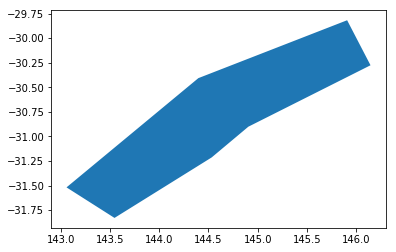

In [ ]:
#plot polygon to check it looks ok
plt.clf()
shape_plot = gpd.read_file(poly_path)
shape_plot.plot()
plt.show()

### query by shapefiles

In [ ]:
## start with may

In [ ]:
shape_file = poly_path
GEOM, SHAPE_NAME = DEADataHandling.open_polygon_from_shapefile(shape_file)
start_of_epoch, end_of_epoch=('2018-05-01', '2018-05-15')
#'time': ('2016-10-01', '2017-04-30')

query = {
    'time': (start_of_epoch, end_of_epoch), 
   # 'time': ('2016-10-01', '2017-04-30'),
    'geopolygon': GEOM,
    'output_crs': 'EPSG:3577',
    'resolution': (-10, 10)
}

##uncomment this to use lat long instead
# query = {
#         'lat': (-35.25, -35.35),
#         'lon': (149.05, 149.17),
#         'output_crs': 'EPSG:3577',
#         'resolution': (-10, 10),
#         'time': ('2017-01-01', '2017-02-15')
#         }

In [ ]:
#load in data
s2= dc.load(product='s2a_ard_granule', group_by='solar_day', 
                   measurements=['fmask', 
                             'nbart_blue', 
                             'nbart_green', 
                             'nbart_red', 
                             'nbart_red_edge_1',
                             'nbart_red_edge_2',
                             'nbart_red_edge_3',
                             'nbart_nir_1',
                             'nbart_nir_2',
                             'nbart_swir_2',
                             'nbart_swir_3'], **query)

#### See what came back from the extraction

In [ ]:
s2

## About Sentinel 2 bands
Sentinel 2 satellites have 13 spectral channels:

| Sentinel 2 bands | DEA band name | Band number | Central wavelength (nm) | Resolution (m) | Bandwidth (nm) |
| -----------------|---------------|-------------|-------------------------|----------------|----------------|
| Coastal aerosol | `nbar(t)_coastal_aerosol` | 1 | 443 | 60 | 20 |
| Blue | `nbar(t)_blue` | 2 | 490 | 10 | 65 |
| Green | `nbar(t)_green` | 3 | 560 | 10 | 35 |
| Red | `nbar(t)_red` | 4 | 665 | 10 | 30 |
| Vegetation red edge | `nbar(t)_red_edge_1` | 5 | 705 | 20 | 15 |
| Vegetation red edge | `nbar(t)_red_edge_2` | 6 | 740 | 20 | 15 |
| Vegetation red edge | `nbar(t)_red_edge_3` | 7 | 783 | 20 | 20 |
| NIR | `nbar(t)_nir_1` | 8 | 842 | 10 | 115 |
| Narrow NIR | `nbar(t)_nir_2` | 8A | 865 | 20 | 20 |
| Water vapour | N/A | 9 | 945 | 60 | 20 |
| SWIR - Cirrus | N/A | 10 | 1375 | 60 | 20 |
| SWIR | `nbar(t)_swir_2` | 11 | 1610 | 20 | 90 |
| SWIR | `nbar(t)_swir_3` | 12 | 2190 | 20 | 180 |

These bands cover the visible, near-infrared and short-wave infrared wave lengths.

![Sentinel 2 bands](http://www.geosage.com/highview/figures/Sentinel2_Spectral_Bands.jpg)

**Note** There are a number of additional datasets that are alse returned from our query. These are a combination of datasets used in the correction process, and layers relating to pixel quality. We will explore the pixel quality layers below.

## Plot this scene up as true colour image

True colour images approximate what the human eye sees when looking at a landscape. Note that the function used for this true colour plot enhances the contrast between the bands, resulting in a colour-enhanced image.

In [ ]:
ds=s2

In [ ]:
# DEAPlotting.three_band_image(ds, bands=['nbar_red', 'nbar_green', 'nbar_blue'],
#                              contrast_enhance=True, time=0)

## Plot this scene up as false colour image

This plot uses the SWIR, NIR and green bands to accentuate the presence of water in the landscape.

In [ ]:
# DEAPlotting.three_band_image(
#     ds, bands=['nbar_swir_2', 'nbar_nir_1', 'nbar_green'], time=1)

## Compare some scenes side-by-side

In [ ]:
# DEAPlotting.three_band_image_subplots(ds, bands=['nbar_swir_2', 'nbar_nir_1', 'nbar_green'],
#                                       num_cols=3, figsize=[10, 10], wspace=0.35)

In [ ]:
#get polygon name from the polygon path
polyname = poly_path.split('/')[-1].split('.')[0]

In [ ]:
savefilepath = '/g/data/r78/rjd547/WaterCompHackFeb2019/Sentinel2Data/'+polyname

In [ ]:
filename=savefilepath

#### this is a really annoying kludge to deal with the fact that new sentinel data has multiple data types and the functions were not written to cope

In [ ]:
ds

## Sneakily force fmask layer to int16 type

In [ ]:
ds['fmask']=ds['fmask'].astype(np.int16)

In [ ]:
ds

In [ ]:
# ### here we drop all the bands with other data types. ###FIXME
# ds = ds.drop([#'terrain_shadow',
#                       #'fmask',
#                       #'nbar_contiguity',
#                       #'nbart_contiguity',
#                      'azimuthal_exiting',
#                      'azimuthal_incident',
#                      'exiting',
#                      'incident',
#                      'relative_azimuth',
#                      'relative_slope',
#                      'satellite_azimuth',
#                       'satellite_view',
#                       'solar_azimuth',
#                       'solar_zenith',
#                       'nbar_coastal_aerosol'                      
#                      ])

# #EK_AEM2.isel(time=i)

In [ ]:
ds

In [ ]:
###Note: I munged this to change the datatype for S2
def dataset_to_geotiff2(filename, data):

    """
    this function uses rasterio and numpy to write a multi-band geotiff for one
    timeslice, or for a single composite image. It assumes the input data is an
    xarray dataset (note, dataset not dataarray) and that you have crs and affine
    objects attached, and that you are using float data. future users
    may wish to assert that these assumptions are correct.
    Last modified: March 2018
    Authors: Bex Dunn and Josh Sixsmith
    Modified by: Claire Krause, Robbi Bishop-Taylor
    inputs
    filename - string containing filename to write out to
    data - dataset to write out
    Note: this function currently requires the data have lat/lon only, i.e. no
    time dimension
    """

    # Depreciation warning for write_geotiff
    print("This function will be superceded by the 'write_geotiff' function from 'datacube.helpers'. "
          "Please revise your notebooks to use this function instead")

    kwargs = {'driver': 'GTiff',
              'count': len(data.data_vars),  # geomedian no time dim
              'width': data.sizes['x'], 'height': data.sizes['y'],
              'crs': data.crs.crs_str,
              'transform': data.affine,
              'dtype': list(data.data_vars.values())[0].values.dtype,
              'nodata': 0,
              'compress': 'deflate', 'zlevel': 4, 'predictor': 2}
    # for ints use 2 for floats use 3}

    with rasterio.open(filename, 'w', **kwargs) as src:
        for i, band in enumerate(data.data_vars):
            src.write(data[band].data, i + 1)

### write the list of bands to a textfile

In [ ]:
band_list =[]
with open(filename+'band_list_s2.txt','w') as outfile: 
    for i, band in enumerate(ds.data_vars):
        #print(str(f'{i+1} {band} \n'))
        outfile.write(str(f'{i+1} {band} \n'))
        #band_list.append([i+1,band])
    #print(band_list)    

### Write each date to a separate geotiff

In [ ]:
print(filename)

In [ ]:
#print the dates for which we have imagery and write to file
for i in range(len(ds.time)):
    date_s2 = str(ds.isel(time=i).time.data)[:-19]
    filename2='{}s2_{}.tif'.format(filename,date_s2)
    print(date_s2)
    dataset_to_geotiff2(filename2, ds.isel(time=i))